# Load the packages and values for volume transport

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# set the grid, months, mask of interest

In [3]:
# iB = 6
m = 1
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = (mymsk < 5) | (mymsk==6) 

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


# Read the files

Here for 2014
For the salt budget we need:
- SALTDR from budg3d_snap_set2
- oceSPflx and SFLUX from budg2d_zflux_set1
- WSLTMASS, oceSflux, SRELAX from budg2d_zflux_set2
- oceSPtnd and KPPg_SLT from budg3d_kpptend_set1
- ADVr_SLT, DFrE_SLT, DFrI_SLT from budg3d_zflux_set2

In [6]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,9])
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [7]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [8]:
file_name = "budg2d_zflux_set1"
oceFWflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceFWflx']),mymsk,dirIn)
SIatmFW = read_field2d(tsstr,ny,nx,file_name,np.array(['SIatmFW']),mymsk,dirIn)
SFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['SFLUX']),mymsk,dirIn)
oceSPflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSPflx']),mymsk,dirIn)

In [9]:
file_name = "budg2d_zflux_set2"
WSLTMASS = read_field2d(tsstr,ny,nx,file_name,np.array(['WSLTMASS']),mymsk,dirIn)
oceSflux = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSflux']),mymsk,dirIn)
SRELAX = read_field2d(tsstr,ny,nx,file_name,np.array(['SRELAX']),mymsk,dirIn)

In [10]:
file_name = "budg3d_zflux_set2"
WVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['WVELMASS']),mymsk,dirIn)
ADVr_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_SLT']),mymsk,dirIn)
DFrE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_SLT']),mymsk,dirIn)
DFrI_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_SLT']),mymsk,dirIn)

In [11]:
file_name = "budg3d_kpptend_set1"
oceSPtnd = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['oceSPtnd']),mymsk,dirIn)
KPPg_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_SLT']),mymsk,dirIn)

In [12]:
file_name = "exf_zflux_set1"
EXFroff = read_field2d(tsstr,ny,nx,file_name,np.array(['EXFroff']),mymsk,dirIn)
EXFpreci = read_field2d(tsstr,ny,nx,file_name,np.array(['EXFpreci']),mymsk,dirIn)
EXFevap = read_field2d(tsstr,ny,nx,file_name,np.array(['EXFevap']),mymsk,dirIn)
EXFempmr = read_field2d(tsstr,ny,nx,file_name,np.array(['EXFempmr']),mymsk,dirIn)

In [13]:
file_name = "budg3d_hflux_set2"
UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

In [14]:
# first have to get the vector values from U and V
# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]
    tmpUadvslt = ADVx_SLT[i]
    tmpVadvslt = ADVy_SLT[i]
    tmpUdfslt = DFxE_SLT[i]
    tmpVdfslt = DFyE_SLT[i]

    # define u and v velocities
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering
    # define in theta
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUadvth,tmpVadvth = tmpUadvth[:,:-1,:-1],tmpVadvth[:,:-1,:-1]     # centering
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = tmpUdfth[:,:-1,:-1],tmpVdfth[:,:-1,:-1]     # centering
    # define in salt
    tmpUadvslt,tmpVadvslt = get_aste_vector_face1_3(tmpUadvslt,tmpVadvslt,nfx,nfy,False)
    tmpUadvslt,tmpVadvslt = tmpUadvslt[:,:-1,:-1],tmpVadvslt[:,:-1,:-1]     # centering
    tmpUdfslt,tmpVdfslt = get_aste_vector_face1_3(tmpUdfslt,tmpVdfslt,nfx,nfy,False)
    tmpUdfslt,tmpVdfslt = tmpUdfslt[:,:-1,:-1],tmpVdfslt[:,:-1,:-1]     # centering

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth
    ADVx_SLTo[i] = tmpUadvslt
    ADVy_SLTo[i] = tmpVadvslt
    DFxE_SLTo[i] = tmpUdfslt
    DFyE_SLTo[i] = tmpVdfslt

In [15]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)[0]

# do the TS binning

In [16]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

# binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = np.linspace(-3, 12, 113)
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [17]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [18]:
# also bin the time mean of theta
binned_theta_tmean = bin_array(np.nanmean(theta,axis=0),binsTH_edges)
binned_theta_tmean = binned_theta_tmean.astype(float)
binned_theta_tmean[binned_theta_tmean == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity_tmean = bin_array(np.nanmean(salt,axis=0),binsSLT_edges)
binned_salinity_tmean = binned_salinity_tmean.astype(float)
binned_salinity_tmean[binned_salinity_tmean == nS] = np.nan

/tmp/ipykernel_272926/497913866.py:2: RuntimeWarning: Mean of empty slice
  binned_theta_tmean = bin_array(np.nanmean(theta,axis=0),binsTH_edges)
/tmp/ipykernel_272926/497913866.py:5: RuntimeWarning: Mean of empty slice
  binned_salinity_tmean = bin_array(np.nanmean(salt,axis=0),binsSLT_edges)


# try to look at surface binning alone

In [19]:
# bin the values in an example month to look at a TS distribution
# Flatten the arrays to use np.add.at
flat_binned_salinity = binned_salinity[:,0,:,:].flatten()
flat_binned_salinity[np.isnan(flat_binned_salinity)] = 0
flat_binned_salinity = flat_binned_salinity.astype(int)

# Flatten the arrays to use np.add.at
flat_binned_salinitym = binned_salinity[m,0,:,:].flatten()
flat_binned_salinitym[np.isnan(flat_binned_salinitym)] = 0
flat_binned_salinitym = flat_binned_salinitym.astype(int)

In [20]:
flat_binned_salinity3d = binned_salinity[:,:,:,:].flatten()
flat_binned_salinity3d[np.isnan(flat_binned_salinity3d)] = 0
flat_binned_salinity3d = flat_binned_salinity3d.astype(int)

# Try to look at each of these convergence terms in the context of the budget

# try to look just at sea ice formation, runoff, evaporation, surface salinity restoring forcing

units for comparison:
- EXFroff - m/s  - need to multiply by RAC
- EXFevap - m/s
- EXFpreci - m/s
- SIatmFW - kg/m^2/s  - need to divide by water density and multiply by RAC
- oceFWflx - kg/m^2/s

In [241]:
# get these in the correct units (Sv)
EXFroffm  = EXFroff[m]  * mygrid["RAC"] * 1e-6     # Sv
EXFevapm  = EXFevap[m]  * mygrid["RAC"] * 1e-6     # Sv
EXFprecim = EXFpreci[m] * mygrid["RAC"] * 1e-6     # Sv

rho_FW = 1000. # kg/m^3
SIatmFWm   = SIatmFW[m]   / rho_FW * mygrid["RAC"] * 1e-6 # Sv
oceFWflxm  = oceFWflx[m]  / rho_FW * mygrid["RAC"] * 1e-6 # Sv

In [242]:
flat_EXFroff  = EXFroffm.flatten()
flat_EXFroff[np.isnan(flat_EXFroff)] = 0

flat_EXFevap = EXFevapm.flatten()
flat_EXFevap[np.isnan(flat_EXFevap)] = 0

flat_EXFpreci = EXFprecim.flatten()
flat_EXFpreci[np.isnan(flat_EXFpreci)] = 0

flat_SIatmFW = SIatmFWm.flatten()
flat_SIatmFW[np.isnan(flat_SIatmFW)] = 0

flat_oceFWflx = oceFWflxm.flatten()
flat_oceFWflx[np.isnan(flat_oceFWflx)] = 0

summed_EXFroff = np.zeros(nS)
np.add.at(summed_EXFroff, flat_binned_salinitym, flat_EXFroff)

summed_EXFevap = np.zeros(nS)
np.add.at(summed_EXFevap, flat_binned_salinitym, flat_EXFevap)

summed_EXFpreci = np.zeros(nS)
np.add.at(summed_EXFpreci, flat_binned_salinitym, flat_EXFpreci)

summed_SIatmFW = np.zeros(nS)
np.add.at(summed_SIatmFW, flat_binned_salinitym, flat_SIatmFW)

summed_oceFWflx = np.zeros(nS)
np.add.at(summed_oceFWflx, flat_binned_salinitym, flat_oceFWflx)

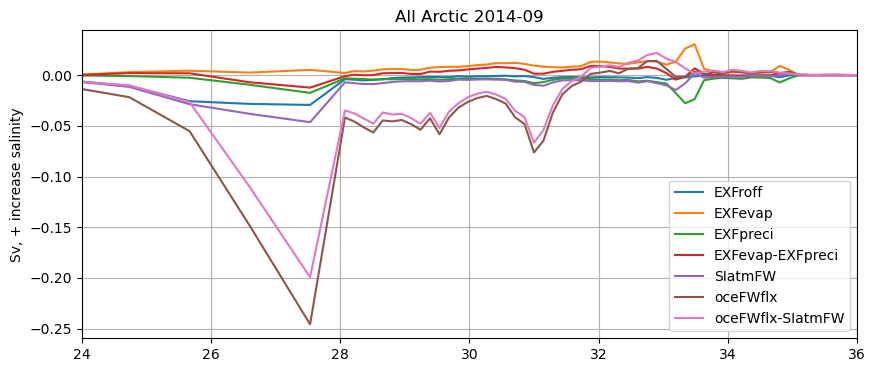

In [323]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,-summed_EXFroff,label="EXFroff")     # decrease salt
plt.plot(binsSLT_centers,summed_EXFevap,label="EXFevap")      
plt.plot(binsSLT_centers,-summed_EXFpreci,label="EXFpreci")
plt.plot(binsSLT_centers,summed_EXFevap-summed_EXFpreci,label="EXFevap-EXFpreci")
plt.plot(binsSLT_centers,-summed_SIatmFW,label="SIatmFW")        # + decrease salt
plt.plot(binsSLT_centers,-summed_oceFWflx,label="oceFWflx")      # + decrease salt
plt.plot(binsSLT_centers,-summed_oceFWflx-(-summed_SIatmFW),label="oceFWflx-SIatmFW")      # + decrease salt

# plt.title("H-Convergence Terms for All 2014")
plt.ylabel("Sv, + increase salinity")
plt.title("All Arctic " + datetimes[m].strftime("%Y-%m"))
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

# plt.savefig(path + "Fig8c_Pemberton_March2014.png",dpi=300)

# also plot for the whole year

In [324]:
# get these in the correct units (Sv)
EXFroffm  = EXFroff  * np.tile(mygrid['RAC'], (len(tsstr), 1, 1)) * 1e-6     # Sv
EXFevapm  = EXFevap  * np.tile(mygrid['RAC'], (len(tsstr), 1, 1)) * 1e-6     # Sv
EXFprecim = EXFpreci * np.tile(mygrid['RAC'], (len(tsstr), 1, 1)) * 1e-6     # Sv

rho_FW = 1000. # kg/m^3
SIatmFWm   = SIatmFW   / rho_FW * np.tile(mygrid['RAC'], (len(tsstr), 1, 1)) * 1e-6 # Sv
oceFWflxm  = oceFWflx  / rho_FW * np.tile(mygrid['RAC'], (len(tsstr), 1, 1)) * 1e-6 # Sv

In [325]:
flat_EXFroff  = EXFroffm.flatten()
flat_EXFroff[np.isnan(flat_EXFroff)] = 0

flat_EXFevap = EXFevapm.flatten()
flat_EXFevap[np.isnan(flat_EXFevap)] = 0

flat_EXFpreci = EXFprecim.flatten()
flat_EXFpreci[np.isnan(flat_EXFpreci)] = 0

flat_SIatmFW = SIatmFWm.flatten()
flat_SIatmFW[np.isnan(flat_SIatmFW)] = 0

flat_oceFWflx = oceFWflxm.flatten()
flat_oceFWflx[np.isnan(flat_oceFWflx)] = 0

summed_EXFroff = np.zeros(nS)
np.add.at(summed_EXFroff, flat_binned_salinity, flat_EXFroff)

summed_EXFevap = np.zeros(nS)
np.add.at(summed_EXFevap, flat_binned_salinity, flat_EXFevap)

summed_EXFpreci = np.zeros(nS)
np.add.at(summed_EXFpreci, flat_binned_salinity, flat_EXFpreci)

summed_SIatmFW = np.zeros(nS)
np.add.at(summed_SIatmFW, flat_binned_salinity, flat_SIatmFW)

summed_oceFWflx = np.zeros(nS)
np.add.at(summed_oceFWflx, flat_binned_salinity, flat_oceFWflx)

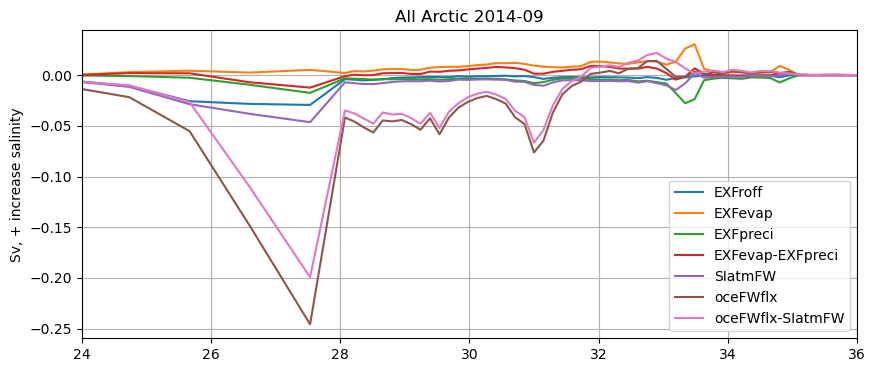

In [326]:
# bin the hconv terms (ADV SLT and DFEslt for x and y)
fig = plt.figure()
plt.plot(binsSLT_centers,-summed_EXFroff,label="EXFroff")     # decrease salt
plt.plot(binsSLT_centers,summed_EXFevap,label="EXFevap")      
plt.plot(binsSLT_centers,-summed_EXFpreci,label="EXFpreci")
plt.plot(binsSLT_centers,summed_EXFevap-summed_EXFpreci,label="EXFevap-EXFpreci")
plt.plot(binsSLT_centers,-summed_SIatmFW,label="SIatmFW")        # + decrease salt
plt.plot(binsSLT_centers,-summed_oceFWflx,label="oceFWflx")      # + decrease salt
plt.plot(binsSLT_centers,-summed_oceFWflx-(-summed_SIatmFW),label="oceFWflx-SIatmFW")      # + decrease salt

# plt.title("H-Convergence Terms for All 2014")
plt.ylabel("Sv, + increase salinity")
plt.title("All Arctic " + datetimes[m].strftime("%Y-%m"))
plt.legend(loc="best")
plt.xlim(24,36)
plt.grid()

# plt.savefig(path + "Fig8c_Pemberton_All2014.png",dpi=300)

# Look at the WMT balance (figure 8b)

- M: boundary volume exchange (gates)
- SE: cumulative surface processes (I think this might make sense to be oceFWflx)
- isopynal transport
- diapycnal transport

### First calculate M

In [327]:
# calculate M, the volume transport at the gates
# look at code done from figure 11
# gates to the Arctic we're interested in:
    # FramStrait
    # CAA
    # BarentsSeaOpening
    # BeringStrait
    # DavisStrait

x1 = gg['FramStrait']["ix"]-1   # 1
y1 = gg['FramStrait']["jy"]-1

x2 = gg['BarentsSeaOpening']["ix"]-1   # 0 
y2 = gg['BarentsSeaOpening']["jy"]-1
x2[x2 == 162] = 161

x3 = gg['CAA']['ix'] -1
y3 = gg['CAA']['jy'] -1

# set Bering Strait manually
x4 = np.array([130,  40, 220, 130,  40, 220, 130,  40, 220, 130,  40, 220, 130,40, 220, 130])
y4 = np.array([813, 814, 814, 815, 816, 816, 817, 818, 818, 819, 820, 820, 821,822, 822, 823])

# set Davis Strait manually
x5 = np.array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119])
y5 = np.array([715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715,
        715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715,
        715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715,
        715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715,
        715, 715, 715, 715, 715, 715, 715, 715])

test = np.full(mskBasin.shape,np.nan)
test[y1,x1] = 1
test[y2,x2] = 2
test[y3,x3] = 3
test[y4,x4] = 4
test[y5,x5] = 5

In [328]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

In [329]:
xs = np.array([x1,x2,x3,x4,x5],dtype="object")
ys = np.array([y1,y2,y3,y4,x5],dtype="object")

In [330]:
# get time mean of velocity
Uom = Uo[m]
Vom = Vo[m]

Uomcompact = aste_tracer2compact(Uom,nfx,nfy)
Vomcompact = aste_tracer2compact(Vom,nfx,nfy)

In [331]:
y_curr,x_curr = y3,x3
gateids = np.array([1,2,3,4,5])
names = np.array(["FramStrait","BarentsSeaOpening","CAA","BeringStrait","DavisStrait"])

totaldistr = np.full((nT,nS),0.0)

for x_curr, y_curr,gateid,name in zip(xs,ys,gateids,names):
    print(gateid)

    # get the u and v components
    uvelgate = Uomcompact[:,y_curr,x_curr]
    vvelgate = Vomcompact[:,y_curr,x_curr]
    
    # get the perpendicular vel
    mygate = np.where(get_aste_tracer(test,nfx,nfy)[0] ==gateid)
    choose_UV = line_orientation(mygate[1],mygate[0])
    choose_UV = np.tile(choose_UV,(nz,1))
    
    # calculate transport velocity
    perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
    for i in range(len(choose_UV)):
        if choose_UV[i][0] == "V":
            perpendicular_vel[i] = uvelgate[i]       # remember to think about proper sign
        elif choose_UV[i][0] == "H":
            if name == "BeringStrait":
                perpendicular_vel[i] = -vvelgate[i]
            else:
                perpendicular_vel[i] = vvelgate[i]
    
    # calculate cell area
    gatemask = mygrid['hFacC'][:,y_curr,x_curr]
    dxggate = mygrid['DXG'][y_curr,x_curr]
    dyggate = mygrid['DYG'][y_curr,x_curr]
    cell_lengths = np.full(choose_UV[0].shape[0],np.nan)
    for i in range(len(choose_UV[0])):
        if choose_UV[0][i] == "V":
            cell_lengths[i] = dyggate[i] #DYG
        elif choose_UV[0][i] == "H":
            cell_lengths[i] = dxggate[i] #DXG
    cell_lengths = np.tile(cell_lengths,(nz,1))
    cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)
    
    # calculate binned S and T
    binned_theta_gate = binned_theta_tmean[:,y_curr,x_curr]
    binned_salinity_gate = binned_salinity_tmean[:,y_curr,x_curr]
    
    data = perpendicular_vel*cell_area*1e-6
    if name == "FramStrait":
        FS_data = data
    
    # data is now the volume transport at the gate, we can bin this with the TS at the gate and plot
    gate_thetabins = binned_theta_tmean[:,y_curr,x_curr]
    gate_saltbins = binned_salinity_tmean[:,y_curr,x_curr]
    
    # get the distribution of volume in TS space
    distr = np.full((nT,nS),0.0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(gate_thetabins[i,j]):
                distr[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += data[i,j]

    totaldistr += distr

1
2
3
4
5


In [332]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
# cmap = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

(-2.0, 7.0)

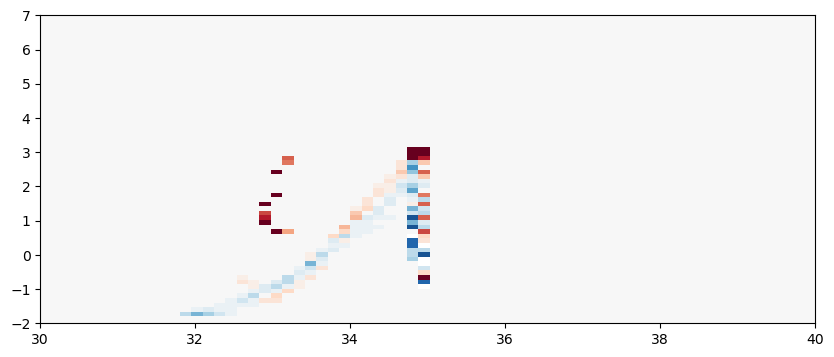

In [333]:
plt.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
plt.xlim(30,40)
plt.ylim(-2,7)

In [334]:
M_salt = np.nansum(totaldistr,axis=1)

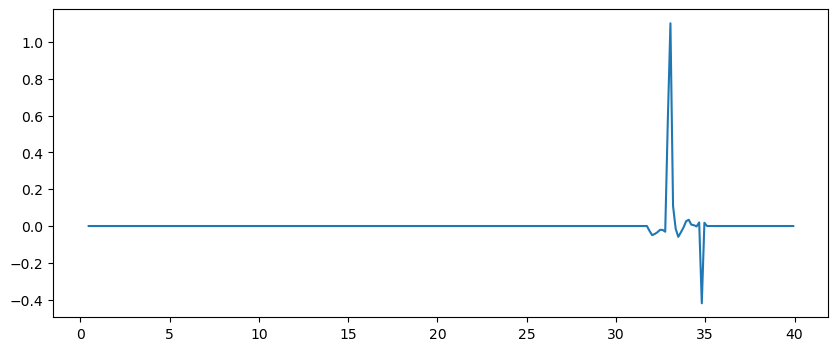

In [335]:
plt.plot(binsSLT_centers,M_salt)

### Now calculate isopycnal and diapycnal transport

In [336]:
# for horizontal gates - use V, for vertical gates - use U

In [337]:
# first calculate rho across the whole domain
densm = gsw.rho(salt[m],theta[m],0) - 1000
densm[np.isnan(densm)] = 0

# first we calculate the density gradients in x/y/z
d_density_dz, d_density_dy, d_density_dx = np.gradient(densm)

# Angles of the isopycnals in the xy-plane, yz-plane, and xz-plane
angle_xy = np.arctan2(d_density_dy[:,y1,x1], d_density_dx[:,y1,x1])
angle_yz = np.arctan2(d_density_dz[:,y1,x1], d_density_dy[:,y1,x1])
angle_xz = np.arctan2(d_density_dz[:,y1,x1], d_density_dx[:,y1,x1])

# get the transport along x y and z
Wo_sel = WVELMASS[m]

In [338]:
# we need to look at volume transport from Uomeancompact, Vomeancompact, and Wo_sel
Uogate_vol = Uomcompact[:,y1,x1] * np.tile(mygrid['DYG'][y1,x1],(nz,1)) * mygrid['DRF'].reshape(nz,1) * 1e-6 #Sv
Vogate_vol = Vomcompact[:,y1,x1] * np.tile(mygrid['DXG'][y1,x1],(nz,1)) * mygrid['DRF'].reshape(nz,1) * 1e-6 #Sv
Wo_sel_vol = Wo_sel[:,y1,x1] * mygrid['RAC'][np.newaxis,y1,x1] * 1e-6 #Sv

In [339]:
# now we can calculate the transport along/across isopycnals
# Across isopycnals in the xy-plane
adv_across_xy = Uogate_vol * np.cos(angle_xy) + Vogate_vol * np.sin(angle_xy)

# Across isopycnals in the yz-plane
adv_across_yz = Vogate_vol * np.cos(angle_yz) - Wo_sel_vol * np.sin(angle_yz)

# Across isopycnals in the xz-plane
adv_across_xz = Uogate_vol * np.cos(angle_xz) + Wo_sel_vol * np.sin(angle_xz)

In [340]:
# Along isopycnals in the xy-plane
adv_along_xy = Uogate_vol * np.sin(angle_xy) + Vogate_vol * np.cos(angle_xy)

# Along isopycnals in the yz-plane
adv_along_yz = Vogate_vol * np.sin(angle_yz) + Wo_sel_vol * np.cos(angle_yz)

# Along isopycnals in the xz-plane
adv_along_xz = Uogate_vol * np.sin(angle_xz) + Wo_sel_vol * np.cos(angle_xz)

In [341]:
# for fram strait (x1,y1) we want advection in xz
binned_salinity_gate = binned_salinity[m][:,y1,x1]
flat_binned_salt = binned_salinity_gate.flatten()
flat_binned_salt[np.isnan(flat_binned_salt)] = -1
flat_binned_salt = flat_binned_salt.astype(int)

In [342]:
test_binsgate = np.full(nS,0)

In [343]:
flat_alongx_isopycnal_adv = (adv_along_yz).flatten()
flat_alongx_isopycnal_adv[np.isnan(flat_alongx_isopycnal_adv)] = 0

advalong_binsgate = np.zeros(nS)
np.add.at(advalong_binsgate, flat_binned_salt, flat_alongx_isopycnal_adv)

In [344]:
flat_acrossx_isopycnal_adv = (adv_across_xz).flatten()
flat_acrossx_isopycnal_adv[np.isnan(flat_acrossx_isopycnal_adv)] = 0

advacross_binsgate = np.zeros(nS)
np.add.at(advacross_binsgate, flat_binned_salt, flat_acrossx_isopycnal_adv)

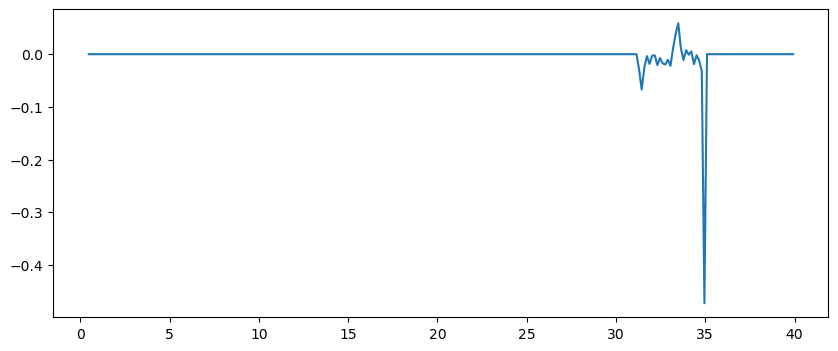

In [345]:
plt.plot(binsSLT_centers,advalong_binsgate)

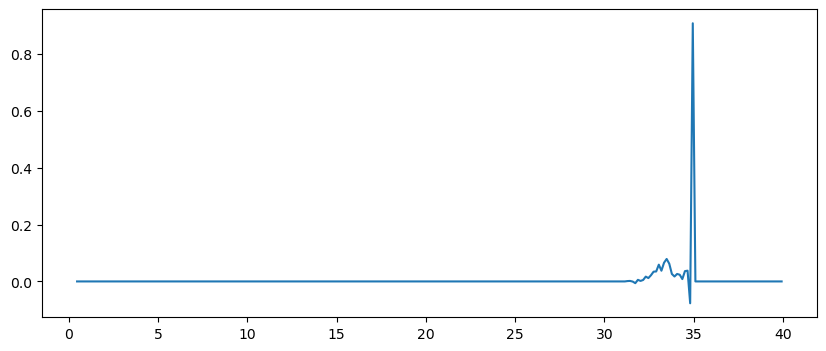

In [346]:
plt.plot(binsSLT_centers,advacross_binsgate)

In [347]:
# # optional sanity check

# # compare this to vertical and horizontal volume transport - does this make sens
# flat_alongx_isopycnal_adv = (Vogate_vol).flatten()
# flat_alongx_isopycnal_adv[np.isnan(flat_alongx_isopycnal_adv)] = 0

# advalong_binsgate = np.zeros(nS)
# np.add.at(advalong_binsgate, flat_binned_salt, flat_alongx_isopycnal_adv)

# flat_acrossx_isopycnal_adv = (Wo_sel_vol).flatten()
# flat_acrossx_isopycnal_adv[np.isnan(flat_acrossx_isopycnal_adv)] = 0

# advacross_binsgate = np.zeros(nS)
# np.add.at(advacross_binsgate, flat_binned_salt, flat_acrossx_isopycnal_adv)

# plt.plot(binsSLT_centers,advacross_binsgate,label="vertical")
# plt.plot(binsSLT_centers,advalong_binsgate,label="horizontal transport")
# plt.legend()

# Let's plot an example at the Fram Strait for this

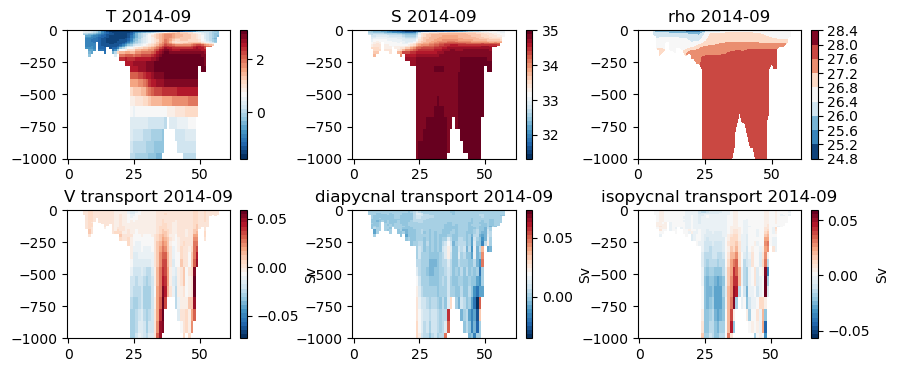

In [348]:
indices = np.arange(0,len(y1),1)
XV,YV= np.meshgrid(indices[::-1],mygrid['RC'])

# 2 by 3 with temperature, salinity, density, V velocity, across and along isopycnal velocity at the strait
fig = plt.figure()

ax = plt.subplot(231)
cb = ax.pcolormesh(XV,YV,theta[m][:,y1,x1],cmap=cmap)
plt.colorbar(cb)
ax.set_title("T "+ datetimes[m].strftime("%Y-%m"))
ax.set_ylim(-1000,0)

ax = plt.subplot(232)
cb = ax.pcolormesh(XV,YV,salt[m][:,y1,x1],cmap=cmap)
plt.colorbar(cb)
ax.set_title("S "+ datetimes[m].strftime("%Y-%m"))
ax.set_ylim(-1000,0)

ax = plt.subplot(233)
c = densm[:,y1,x1]
c[c == 0] = np.nan
cb = ax.contourf(XV,YV,c,cmap=cmap)
plt.colorbar(cb)
ax.set_title("rho "+ datetimes[m].strftime("%Y-%m"))
ax.set_ylim(-1000,0)

ax = plt.subplot(234)
c = Vogate_vol
c[c == 0] = np.nan
cb = ax.pcolormesh(XV,YV,c,cmap=cmap)
plt.colorbar(cb,label="Sv")
ax.set_title("V transport "+ datetimes[m].strftime("%Y-%m"))
ax.set_ylim(-1000,0)

ax = plt.subplot(235)
c = adv_across_yz
c[c == 0] = np.nan
cb = ax.pcolormesh(XV,YV,c,cmap=cmap)
plt.colorbar(cb,label="Sv")
ax.set_title("diapycnal transport "+ datetimes[m].strftime("%Y-%m"))
ax.set_ylim(-1000,0)

ax = plt.subplot(236)
c = adv_along_yz
c[c == 0] = np.nan
cb = ax.pcolormesh(XV,YV,c,cmap=cmap)
plt.colorbar(cb,label="Sv")
ax.set_title("isopycnal transport "+ datetimes[m].strftime("%Y-%m"))
ax.set_ylim(-1000,0)

plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.savefig(path + "September2014_FramStrait_xyz.png",dpi=300)

# Now create the Pemberton Fig 8b using S coordinates

In [349]:
# sample using a as the Fram strait
gate_thetabins = binned_theta_tmean[:,y1,x1]
gate_saltbins = binned_salinity_tmean[:,y1,x1]
distr = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distr[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += FS_data[i,j]

In [350]:
M_salt_FS = np.nansum(distr,axis=1)
# M_salt_FS

In [378]:
binned_salinity_gate.shape

(50, 62)

In [379]:
flat_oceFWflx = oceFWflxm[m,y1,x1].flatten()
flat_oceFWflx[np.isnan(flat_oceFWflx)] = 0

summed_oceFWflx = np.zeros(nS)
gate = binned_salinity_gate[0].flatten()
gate[np.isnan(gate)] = 0
np.add.at(summed_oceFWflx, gate.astype(int), flat_oceFWflx)

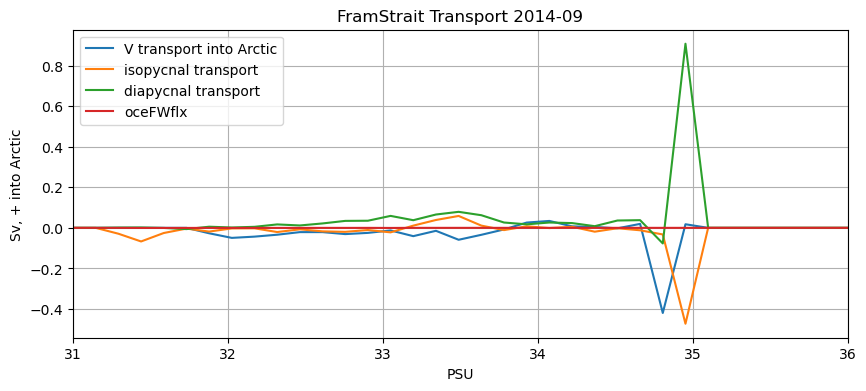

In [383]:
# this makes sense for FS because most of the diapycnal transport is happening on the western half/where transportr
plt.plot(binsSLT_centers,M_salt_FS,label="V transport into Arctic")
plt.plot(binsSLT_centers,advalong_binsgate,label="isopycnal transport")
plt.plot(binsSLT_centers,advacross_binsgate,label="diapycnal transport")
plt.plot(binsSLT_centers,-summed_oceFWflx,label="oceFWflx")      # + decrease salt
plt.ylabel("Sv, + into Arctic")
plt.xlabel("PSU")
plt.title("FramStrait Transport " + datetimes[m].strftime("%Y-%m"))
plt.xlim(31,36)
plt.legend()
plt.grid()
plt.savefig(path + "MarchstartingPemberton_Fig8b_withsurface.png",dpi=300)